# Deep Ensemble from Neural Architecture Search

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deephyper/anl-22-summer-workshop/blob/main/notebooks/3-Ensemble-and-Uncertainty-Quantification.ipynb)

In this tutorial we will present leverage the outcomes from neural architecture to build ensemble and performe uncertainty quantification for timeseries on the sea-surface temperature prediction problem.

In [ ]:
IN_COLAB = False
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
print(IN_COLAB)

False


In [ ]:
#Install dependencies if running in google collab
if IN_COLAB:
    !rm -rf deephyper_repo/
    !git clone -b develop https://github.com/deephyper/deephyper.git deephyper_repo
    !pip install -e "deephyper_repo/[nas,popt,autodeuq]" --use-feature=in-tree-build
    !pip install matplotlib==3.5.2
    !git clone https://github.com/deephyper/anl-22-summer-workshop.git

In [ ]:
# Download the data if running in google collab
if IN_COLAB:
    %cd /content/anl-22-summer-workshop/notebooks/data
    !gdown 1J4kU3j49B9xWRpALgr8d90BjJCnwhAOS
    !gdown 1fuHM93OUcu536Ux6p2Oandbi3BrGl8vh
    !gdown 1fXHrFpM21LMUFj-S7jXLI4yZcJi3oAaU
    %cd /content/anl-22-summer-workshop/notebooks/

In [1]:
import gzip

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

from data.utils import load_sst_data, load_data_prepared

from deephyper.nas.metrics import r2

In [2]:
available_gpus = tf.config.list_physical_devices("GPU")
n_gpus = len(available_gpus)
if n_gpus > 1:
    n_gpus -= 1
is_gpu_available = n_gpus > 0

if is_gpu_available:
    print(f"{n_gpus} GPU{'s are' if n_gpus > 1 else ' is'} available.")
else:
    print("No GPU available")

No GPU available


## The data

Let's start by loading the raw training data with shape `(timestep, latitude, longitude)` containing temperature with Celsius as unit

In [3]:
train_data, test_data, mask = load_sst_data()
train_data.shape

(427, 180, 360)

Then we can visualize a specific timestep (the first week), let's try with the first one.

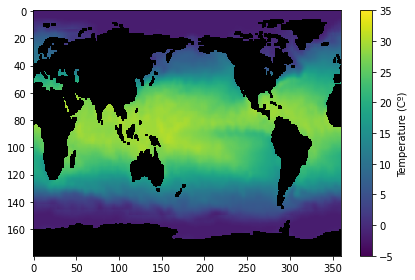

In [4]:
palette = plt.cm.viridis.with_extremes(over='r', under='r', bad='black')

idx = 0
snapshot = train_data[idx].copy()
snapshot[np.where(mask[0] == 0)] = 100
snapshot_masked = np.ma.masked_where(snapshot == 100, snapshot)


plt.figure()
im = plt.imshow(snapshot_masked, cmap=palette, vmin=-5,vmax=35, aspect="auto")
plt.colorbar(im, label="Temperature (Cº)")
plt.tight_layout()
plt.show()

## Baseline LSTM Model

In [5]:
def nll(y, rv_y):
    """Negative log likelihood for Tensorflow probability.

    Args:
        y: true data.
        rv_y: learned (predicted) probability distribution.
    """
    return -rv_y.log_prob(y)

In [6]:
def build_and_train_model(config: dict, n_components: int=5, verbose: bool=0):
    
    default_config = {
        "lstm_units": 128,
        "activation": "tanh",
        "recurrent_activation": "sigmoid",
        "learning_rate": 1e-3,
        "batch_size": 8,

    }
    default_config.update(config)
    
    (X_train, y_train), (X_valid, y_valid), _, _= load_data_prepared(n_components=n_components)
    
    model = tf.keras.Sequential([
        tf.keras.Input(shape=X_train.shape[1:]),
        tf.keras.layers.LSTM(default_config["lstm_units"], 
            activation=default_config["activation"], 
            recurrent_activation=default_config["recurrent_activation"],
            return_sequences=True),
        tf.keras.layers.Dense(n_components*2),
        tfp.layers.DistributionLambda(
            lambda t: tfd.Normal(
                loc=t[..., :n_components],
                scale=1e-3 + tf.math.softplus(0.05 * t[..., n_components:]),
            )
        )

    ])
    
    if verbose:
        model.summary()
        
    optimizer = tf.keras.optimizers.Adam(learning_rate=default_config["learning_rate"])
    model.compile(optimizer, loss=nll, metrics=[])
    
    history = model.fit(X_train, y_train, 
        epochs=80,
        batch_size=default_config["batch_size"],
        validation_data=(X_valid, y_valid),
        verbose=verbose
    ).history

    return model, history

In [7]:
n_components = 5

model, history = build_and_train_model(config={}, n_components=n_components, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8, 128)            68608     
                                                                 
 dense (Dense)               (None, 8, 10)             1290      
                                                                 
 distribution_lambda (Distri  ((None, 8, 5),           0         
 butionLambda)                (None, 8, 5))                      
                                                                 
Total params: 69,898
Trainable params: 69,898
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80


2022-07-06 15:12:17.412181: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-07-06 15:12:17.440009: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


52/52 [==============================] - 1s 10ms/step - loss: 1.0847 - val_loss: 0.8651
Epoch 2/80
52/52 [==============================] - 0s 4ms/step - loss: 0.8384 - val_loss: 0.8055
Epoch 3/80
52/52 [==============================] - 0s 4ms/step - loss: 0.7804 - val_loss: 0.7613
Epoch 4/80
52/52 [==============================] - 0s 4ms/step - loss: 0.7281 - val_loss: 0.7307
Epoch 5/80
52/52 [==============================] - 0s 4ms/step - loss: 0.6716 - val_loss: 0.6651
Epoch 6/80
52/52 [==============================] - 0s 4ms/step - loss: 0.5713 - val_loss: 0.5691
Epoch 7/80
52/52 [==============================] - 0s 4ms/step - loss: 0.4089 - val_loss: 0.4621
Epoch 8/80
52/52 [==============================] - 0s 4ms/step - loss: 0.3029 - val_loss: 0.3704
Epoch 9/80
52/52 [==============================] - 0s 4ms/step - loss: 0.1835 - val_loss: 0.3759
Epoch 10/80
52/52 [==============================] - 0s 4ms/step - loss: 0.1452 - val_loss: 0.3543
Epoch 11/80
52/52 [==========

Let us check the learning performance of this baseline

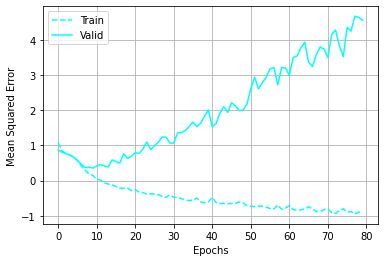

In [8]:
plt.figure()
plt.plot(history["loss"], color="cyan", linestyle="--", label="Train")
plt.plot(history["val_loss"], color="cyan", linestyle="-", label="Valid")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.legend()
plt.show()

In [9]:
cached_data = "processed_data.npz"
with gzip.GzipFile(cached_data, "rb") as f:
    data = np.load(f, allow_pickle=True).item()
    X_train, y_train = data["train"]
    X_valid, y_valid = data["valid"]
    X_test, y_test = data["test"]
    preprocessor = data["preprocessor"]

y_pred = model.predict(X_train)
shape = y_pred.shape
y_pred = y_pred.reshape(-1, shape[-1])
y_pred = preprocessor.inverse_transform(y_pred).reshape((*shape[:2], -1))

We can also visualize a prediction

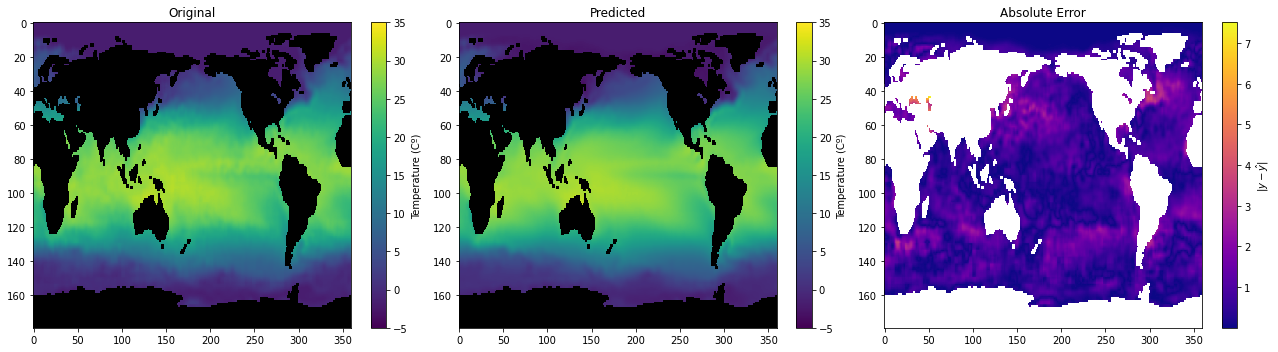

In [10]:
idx = 9 # should be > than input_horizon!
snapshot = train_data[idx].copy()
snapshot[np.where(mask[0] == 0)] = 100
snapshot_masked_full = np.ma.masked_where(snapshot == 100, snapshot)

input_horizon = X_train.shape[1]
inv_y_pred = y_pred[idx-input_horizon][0].reshape(train_data.shape[1:])
snapshot = inv_y_pred.copy()
snapshot[np.where(mask[0] == 0)] = 100
snapshot_masked_redu = np.ma.masked_where(snapshot == 100, snapshot)

plt.figure(figsize=(18, 5))
ax = plt.subplot(1, 3, 1)
ax.set_title("Original")
im = plt.imshow(snapshot_masked_full, cmap=palette, vmin=-5,vmax=35, aspect="auto")
plt.colorbar(im, label="Temperature (Cº)")
plt.tight_layout()

ax = plt.subplot(1, 3, 2)
ax.set_title("Predicted")

im = plt.imshow(snapshot_masked_redu, cmap=palette, vmin=-5,vmax=35, aspect="auto")
plt.colorbar(im, label="Temperature (Cº)")
plt.tight_layout()

ax = plt.subplot(1, 3, 3)
ax.set_title("Absolute Error")
err = np.abs(snapshot_masked_full - snapshot_masked_redu)
im = plt.imshow(err, cmap="plasma", aspect="auto")
plt.colorbar(im, label="$|y - \hat{y}|$")
plt.tight_layout()

plt.show()

In [11]:
from deephyper.nas.metrics import r2, mse

scores = {"MSE": mse, "R2": r2}

for metric_name, metric_func in scores.items():
    print(f"Metric {metric_name}")
    y_pred = model.predict(X_train)
    score_train = np.mean(metric_func(y_train, y_pred).numpy())

    y_pred = model.predict(X_valid)
    score_valid = np.mean(metric_func(y_valid, y_pred).numpy())

    y_pred = model.predict(X_test)
    score_test = np.mean(metric_func(y_test, y_pred).numpy())

    print(f"{score_train=}")
    print(f"{score_valid=}")
    print(f"{score_test=}")
    print()

Metric MSE
score_train=0.04833845
score_valid=0.16389014
score_test=0.21820591

Metric R2
score_train=0.9512352
score_valid=0.7750721
score_test=0.7065663



## Neural Architecture Search

Wrapping the data in a `load_data` function

In [12]:
def load_data():

    (X_train, y_train), (X_valid, y_valid), _, _ = load_data_prepared()

    return (X_train, y_train), (X_valid, y_valid)

    

Definition the neural architecture search space

In [13]:
import collections

from deephyper.nas import KSearchSpace 
from deephyper.nas.node import ConstantNode, VariableNode
from deephyper.nas.operation import operation, Zero, Identity, Connect, AddByProjecting


Dense = operation(tf.keras.layers.Dense)
LSTM = operation(tf.keras.layers.LSTM)
DistributionLambda = operation(tfp.layers.DistributionLambda)

class VStackedLSTMSpace(KSearchSpace):
    def __init__(self, input_shape, output_shape, seed=None, num_layers=5):
        super().__init__(input_shape, output_shape, seed=seed)

        self.num_layers = num_layers
        self.output_dim = output_shape[-1]

    def build(self):
        source = prev_input = self.input_nodes[0]

        # look over skip connections within a range of the 2 previous nodes
        anchor_points = collections.deque([source], maxlen=2)

        for _ in range(self.num_layers):
            vnode = VariableNode()
            self.add_lstm_seq_(vnode)

            self.connect(prev_input, vnode)

            # * Cell output
            cell_output = vnode

            cmerge = ConstantNode()
            cmerge.set_op(AddByProjecting(self, [cell_output], activation="relu"))

            for anchor in anchor_points:
                skipco = VariableNode()
                skipco.add_op(Zero())
                skipco.add_op(Connect(self, anchor))
                self.connect(skipco, cmerge)

            #! for next iter
            prev_input = cmerge
            anchor_points.append(prev_input)

        cnode = ConstantNode(op=Dense(self.output_dim * 2))  # means and stddev
        self.connect(prev_input, cnode)

        out_node = ConstantNode(
            op=DistributionLambda(
                lambda t: tfd.Normal(
                    loc=t[..., :self.output_dim],
                    scale=1e-3 + tf.math.softplus(0.05 * t[..., self.output_dim:]),
                )
            )
        )
        self.connect(cnode, out_node)

        return self

    def add_lstm_seq_(self, node):
        node.add_op(Identity())  # we do not want to create a layer in this case
        for units in range(16, 129, 16):
            node.add_op(LSTM(units=units, return_sequences=True))

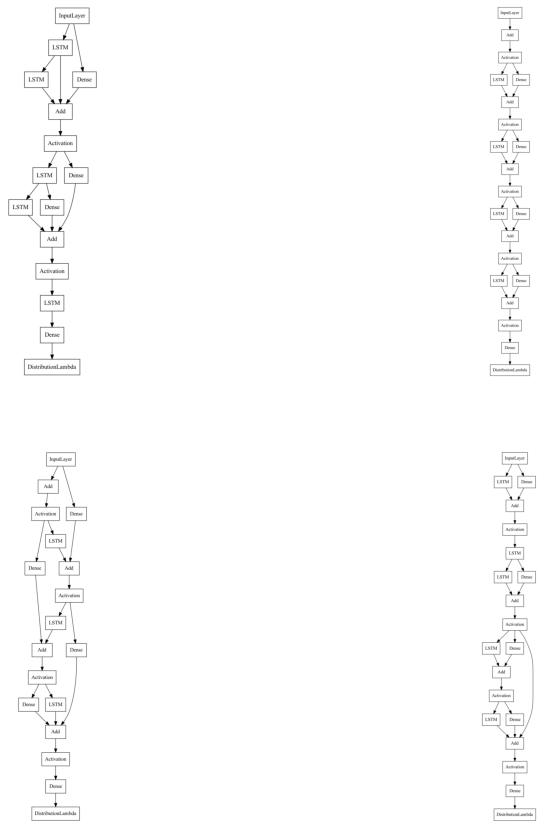

In [14]:
import matplotlib.image as mpimg
from tensorflow.keras.utils import plot_model

shapes = dict(input_shape=(8,5), output_shape=(8,5))
space = VStackedLSTMSpace(**shapes).build()

images = []
plt.figure(figsize=(15,15))
for i in range(4):

    model = space.sample()
    plt.subplot(2,2,i+1)
    plot_model(model, "random_model.png", show_shapes=False, show_layer_names=False)
    image = mpimg.imread("random_model.png")
    plt.imshow(image)
    plt.axis('off')

plt.show()

In [15]:
from deephyper.problem import NaProblem


problem = NaProblem()

problem.load_data(load_data)


problem.search_space(VStackedLSTMSpace, )

problem.hyperparameters(
    batch_size=8,
    learning_rate=1e-3,
    optimizer="adam",
    num_epochs=80,
    callbacks=dict(
        ReduceLROnPlateau=dict(
                monitor="val_loss", mode="min", verbose=0, patience=15
        ),
        EarlyStopping=dict(
            monitor="loss", 
            mode="min",
            verbose=0,
            patience=20
        ),
        ModelCheckpoint=dict(
            monitor="val_loss",
            mode="min",
            save_best_only=True,
            verbose=0,
            filepath="model.h5",
            save_weights_only=False,
        )
    )
)

problem.loss(nll) 

problem.metrics([]) 

problem.objective('-val_loss') 
problem

Problem is:
    - search space   : __main__.VStackedLSTMSpace
    - data loading   : __main__.load_data
    - preprocessing  : None
    - hyperparameters: 
        * verbose: 0
        * batch_size: 8
        * learning_rate: 0.001
        * optimizer: adam
        * num_epochs: 80
        * callbacks: {'ReduceLROnPlateau': {'monitor': 'val_loss', 'mode': 'min', 'verbose': 0, 'patience': 15}, 'EarlyStopping': {'monitor': 'loss', 'mode': 'min', 'verbose': 0, 'patience': 20}, 'ModelCheckpoint': {'monitor': 'val_loss', 'mode': 'min', 'save_best_only': True, 'verbose': 0, 'filepath': 'model.h5', 'save_weights_only': False}}
    - loss           : <function nll at 0x2993ea550>
    - metrics        : 
    - objective      : -val_loss

Definition of the function to optimize

Execution of a genetic algorithm for the search

In [24]:
from deephyper.search.nas import RegularizedEvolution
from deephyper.nas.run import run_base_trainer


regevo_search = RegularizedEvolution(problem, run_base_trainer, log_dir="regevo-uq-results")
results = regevo_search.search(max_evals=10)

  0%|          | 0/10 [00:00<?, ?it/s]

In [25]:
results

,arch_seq,job_id,objective,timestamp_submit,timestamp_gather
0,"[8, 0, 2, 1, 0, 1, 0, 1, 2, 0, 0, 4, 1, 0]",1,-3.637676,0.011001,48.034559
1,"[3, 0, 8, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0]",2,-2.576692,48.068337,76.473783
2,"[4, 0, 6, 1, 1, 6, 1, 1, 0, 1, 1, 1, 1, 1]",3,-3.704410,76.475138,119.092267
3,"[2, 0, 3, 1, 0, 6, 1, 1, 1, 0, 1, 5, 0, 1]",4,-3.915950,119.093539,166.201246
4,"[8, 1, 5, 1, 0, 6, 1, 1, 0, 0, 0, 4, 1, 0]",5,-8.139595,166.202623,218.997694
5,"[3, 0, 8, 1, 1, 4, 1, 0, 1, 1, 1, 6, 0, 1]",6,-3.996999,218.998821,274.700990
6,"[0, 0, 7, 1, 1, 5, 1, 1, 6, 0, 1, 0, 1, 0]",7,-6.612961,274.702143,316.336764
7,"[4, 0, 3, 1, 0, 2, 1, 0, 6, 0, 1, 3, 1, 0]",8,-2.462216,316.338034,362.528272
8,"[0, 0, 4, 0, 1, 5, 0, 1, 1, 1, 1, 8, 0, 0]",9,-3.867257,362.529530,406.027134
9,"[1, 1, 0, 0, 1, 4, 0, 0, 0, 1, 1, 3, 0, 1]",10,-2.889496,406.028673,433.067997


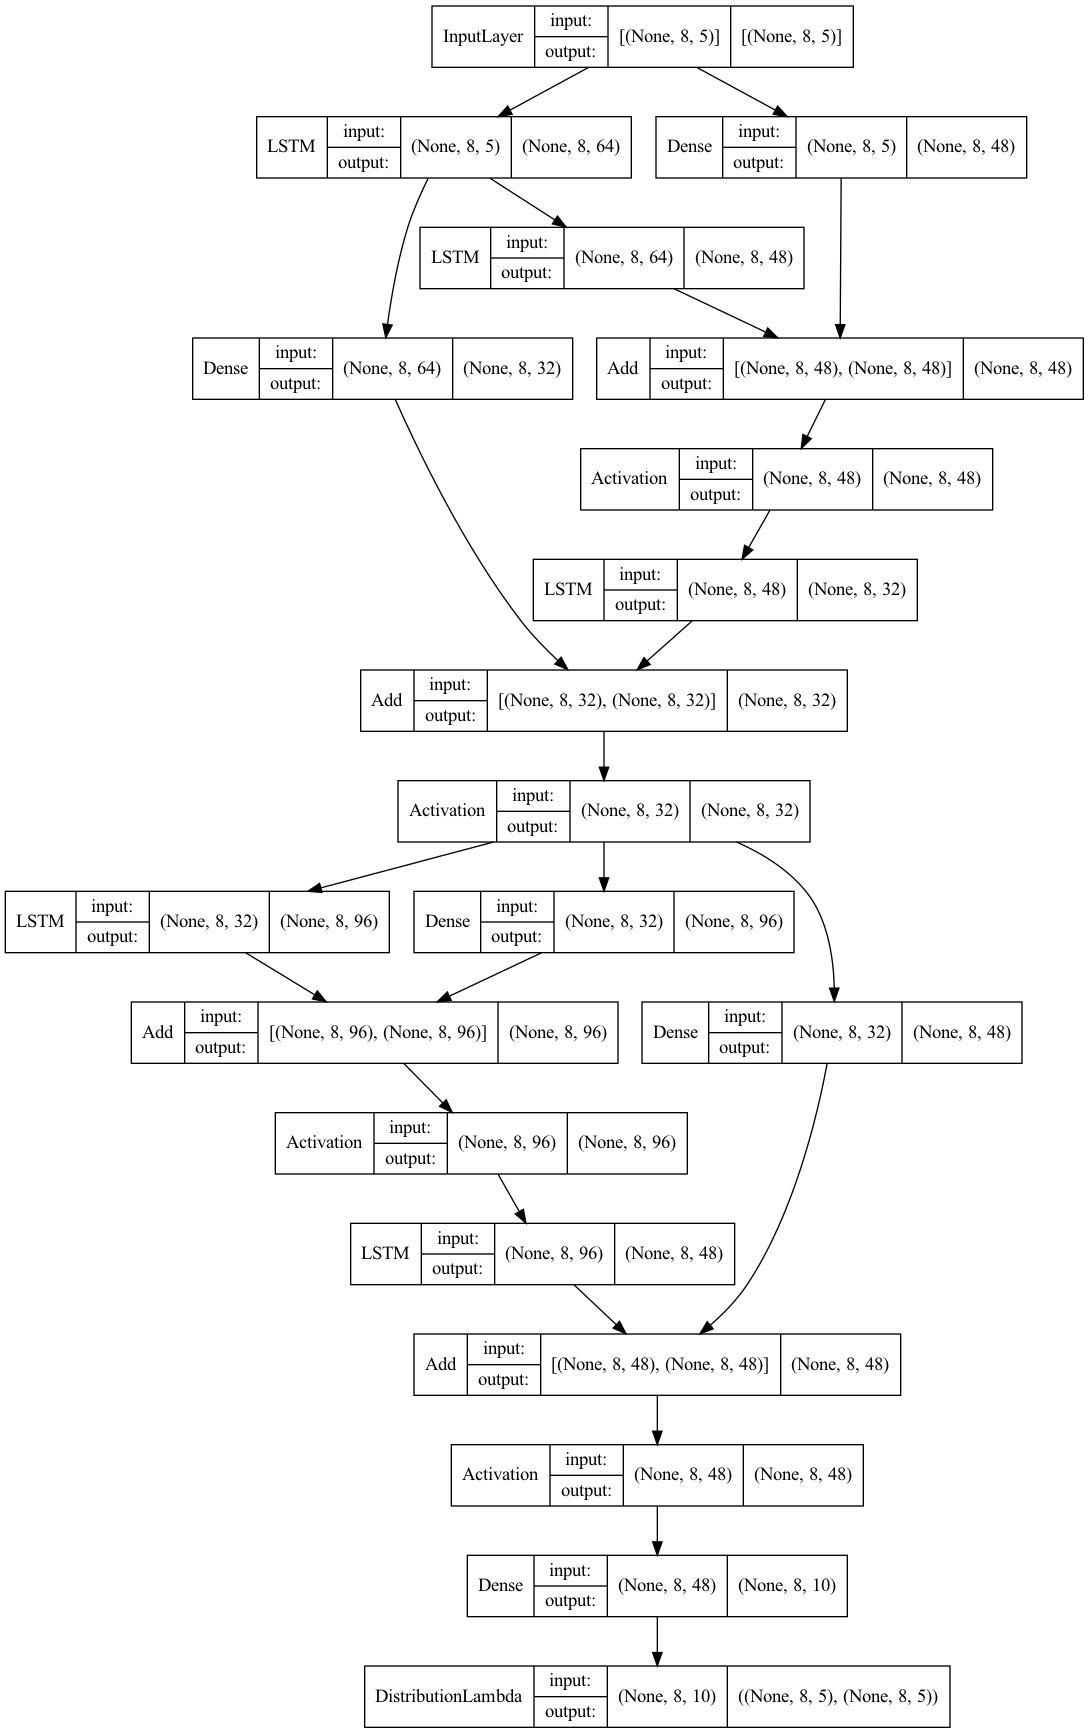

In [26]:
import json


i_max = results.objective.argmax()
best_score = results.iloc[i_max].objective
best_job_id = results.iloc[i_max].job_id
best_arch_seq = json.loads(results.iloc[i_max].arch_seq)

best_model = space.sample(best_arch_seq)
plot_model(best_model, show_shapes=True, show_layer_names=False)

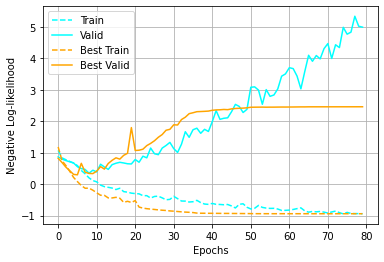

In [27]:
with open(f"regevo-uq-results/save/history/{best_job_id}.json", "r") as f:
    best_history = json.load(f)

plt.figure()
plt.plot(history["loss"], color="cyan", linestyle="--", label="Train")
plt.plot(history["val_loss"], color="cyan", linestyle="-", label="Valid")
plt.plot(best_history["loss"], color="orange", linestyle="--", label="Best Train")
plt.plot(best_history["val_loss"], color="orange", linestyle="-", label="Best Valid")
plt.xlabel("Epochs")
plt.ylabel("Negative Log-likelihood")
plt.grid()
plt.legend()
plt.show()

In [28]:
best_model = tf.keras.models.load_model(f"regevo-uq-results/save/model/{best_job_id}.h5", compile=False)

In [29]:
y_pred_best =  best_model.predict(X_train)
shape = y_pred_best.shape
y_pred_best = y_pred_best.reshape(-1, shape[-1])
y_pred_best = preprocessor.inverse_transform(y_pred_best).reshape((*shape[:2], -1))

In [16]:
def inverse_transform(x):
    y =  best_model.predict(x)
    shape = y.shape
    y = y.reshape(-1, shape[-1])
    y = preprocessor.inverse_transform(y).reshape((*shape[:2], -1))
    return y

In [31]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.batch(batch_size)

def batch_predict(dataset, convert_func=lambda x: x):
    y_list = []
    for batch in dataset:
        y = model(batch, training=False)
        y_list.append(convert_func(y))
    y = np.concatenate(y_list, axis=0)
    return y

convert_func = lambda y_dist: np.concatenate(
    [y_dist.loc, y_dist.scale], axis=-1
)
y_pred_best = batch_predict(dataset, convert_func)

mu = y_pred_best[:,:,:n_components]
std = y_pred_best[:,:,n_components:]

In [32]:
mu_ci = mu + 1.96*std
mu_full = inverse_transform(mu)
mu_ci_full = inverse_transform(mu_ci)
uq = np.abs(mu_full - mu_ci_full)
uq.shape

(411, 8, 64800)

In [48]:
X_train.shape

(275, 8, 5)

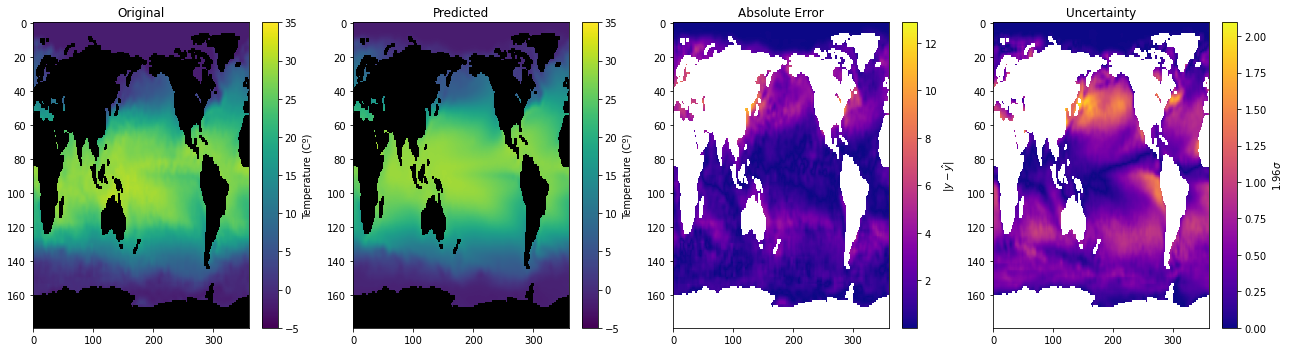

In [36]:
idx = 9 # should be > than input_horizon!
snapshot = train_data[idx].copy()
snapshot[np.where(mask[0] == 0)] = 100
snapshot_masked_full = np.ma.masked_where(snapshot == 100, snapshot)

input_horizon = X_train.shape[1]
inv_y_pred = mu_ci_full[idx-input_horizon][0].reshape(train_data.shape[1:])
snapshot = inv_y_pred.copy()
snapshot[np.where(mask[0] == 0)] = 100
snapshot_masked_redu = np.ma.masked_where(snapshot == 100, snapshot)

input_horizon = X_train.shape[1]
inv_uq = uq[idx-input_horizon][0].reshape(train_data.shape[1:])
snapshot = inv_uq.copy()
snapshot[np.where(mask[0] == 0)] = 100
snapshot_masked_uq = np.ma.masked_where(snapshot == 100, snapshot)


plt.figure(figsize=(18, 5))
ax = plt.subplot(1, 4, 1)
ax.set_title("Original")
im = plt.imshow(snapshot_masked_full, cmap=palette, vmin=-5,vmax=35, aspect="auto")
plt.colorbar(im, label="Temperature (Cº)")
plt.tight_layout()

ax = plt.subplot(1, 4, 2)
ax.set_title("Predicted")

im = plt.imshow(snapshot_masked_redu, cmap=palette, vmin=-5,vmax=35, aspect="auto")
plt.colorbar(im, label="Temperature (Cº)")
plt.tight_layout()

ax = plt.subplot(1, 4, 3)
ax.set_title("Absolute Error")
err = np.abs(snapshot_masked_full - snapshot_masked_redu)
im = plt.imshow(err, cmap="plasma", aspect="auto")
plt.colorbar(im, label="$|y - \hat{y}|$")
plt.tight_layout()

ax = plt.subplot(1, 4, 4)
ax.set_title("Uncertainty")
im = plt.imshow(snapshot_masked_uq, cmap="plasma", aspect="auto")
plt.colorbar(im, label="$1.96 \sigma$")
plt.tight_layout()

plt.show()

In [38]:
scores = {"MSE": mse, "R2": r2}

for metric_name, metric_func in scores.items():
    print(f"Metric {metric_name}")
    y_pred = best_model.predict(X_train)
    score_train = np.mean(metric_func(y_train, y_pred).numpy())

    y_pred = best_model.predict(X_valid)
    score_valid = np.mean(metric_func(y_valid, y_pred).numpy())

    y_pred = best_model.predict(X_test)
    score_test = np.mean(metric_func(y_test, y_pred).numpy())

    print(f"{score_train=}")
    print(f"{score_valid=}")
    print(f"{score_test=}")
    print()

Metric MSE
score_train=0.14706859
score_valid=0.21148565
score_test=0.31006175

Metric R2
score_train=0.8562727
score_valid=0.71996456
score_test=0.60671234



In [17]:
import ray

from deephyper.ensemble import UQBaggingEnsembleRegressor

if not(ray.is_initialized()):
    ray.init()


ensemble = UQBaggingEnsembleRegressor(
    model_dir="regevo-uq-results/save/model",
    loss=nll,  # default is nll
    size=5,
    verbose=True,
    ray_address="auto",
    num_cpus=1,
    num_gpus=1 if is_gpu_available else None,
    selection="caruana",
)

ensemble.fit(X_valid, y_valid)

print(f"Selected {len(ensemble.members_files)} members are: ", ensemble.members_files)

(model_predict pid=6653) Loading model 4.h5
(model_predict pid=6654) Loading model 6.h5
(model_predict pid=6656) Loading model 2.h5
(model_predict pid=6650) Loading model 9.h5
(model_predict pid=6655) Loading model 1.h5
(model_predict pid=6648) Loading model 10.h5
(model_predict pid=6649) Loading model 5.h5
(model_predict pid=6657) Loading model 8.h5
(model_predict pid=6652) Loading model 3.h5
(model_predict pid=6651) Loading model 7.h5


(model_predict pid=6648) 2022-07-06 15:13:05.758736: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
(model_predict pid=6656) 2022-07-06 15:13:05.663273: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
(model_predict pid=6656) 2022-07-06 15:13:05.679334: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
(model_predict pid=6651) 2022-07-06 15:13:05.754016: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
(model_predict pid=6649) 2022-07-06 15:13:05.848977: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
(model_predict pid=6648) 2

ValueError: Arguments `loc` and `scale` must have compatible shapes; loc.shape=(10, 8, 0, 10), scale.shape=(10, 8, 5, 10).